In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [4]:
import os 
import sys

In [5]:
print(os.getcwd())


c:\Users\h\Desktop\weak 8 and 9\notebooks


In [6]:
df=pd.read_csv('../Data/Fraud_Data.csv')
df1=pd.read_csv('../Data/IpAddress_to_Country.csv')


In [7]:
df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [8]:
df.tail()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0
151111,138208,2015-06-10 07:02:20,2015-07-21 02:03:53,20,ZINIADFCLHYPG,Direct,IE,M,38,4.103825e+09,0


by extracting only the columns that has value 1 or fradalent transaction we ca n study the the relation betweeen fraud and Purchase time,device and related terms

In [14]:
df_1 = df[df['class'] == 1]
df_1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1
...,...,...,...,...,...,...,...,...,...,...,...
151082,305464,2015-01-07 09:06:55,2015-01-07 09:06:56,90,TVYSUZLTILQQN,SEO,IE,M,34,3.067794e+09,1
151099,115473,2015-01-01 07:26:14,2015-01-01 07:26:15,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,1
151103,5557,2015-01-04 23:03:04,2015-01-04 23:03:05,27,AWFGZTEHXMWEJ,Direct,Chrome,M,39,3.306999e+09,1
151104,252360,2015-01-04 09:40:44,2015-01-04 09:40:45,20,GSEYHMCBONPHK,Ads,IE,F,39,2.698870e+09,1


In [25]:
most_common_device = df_1.idxmax()
frequency = df_1.max()
print("Most common fraudulent device_id:", most_common_device, "with", frequency, "occurrences")


Most common fraudulent device_id: user_id           109602
signup_time        62187
purchase_time     142811
purchase_value     98920
device_id          71151
source                 2
browser               83
sex                    2
age                71597
ip_address         32353
class                  2
dtype: int64 with user_id                        400000
signup_time       2015-08-18 04:31:11
purchase_time     2015-12-13 12:00:36
purchase_value                    111
device_id               ZZUBRTQITHWAO
source                            SEO
browser                        Safari
sex                                 M
age                                68
ip_address           4294131339.76076
class                               1
dtype: object occurrences


the device ID ZZUBRTQITHWAO the one which most fraudalent activity is performed so we have to prevent any types of transaction from the device

Check if transactions from a specific device_id tend to have higher or lower purchase values.

In [27]:
df_1.groupby('device_id')['purchase_value'].describe()
df_1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1
...,...,...,...,...,...,...,...,...,...,...,...
151082,305464,2015-01-07 09:06:55,2015-01-07 09:06:56,90,TVYSUZLTILQQN,SEO,IE,M,34,3.067794e+09,1
151099,115473,2015-01-01 07:26:14,2015-01-01 07:26:15,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,1
151103,5557,2015-01-04 23:03:04,2015-01-04 23:03:05,27,AWFGZTEHXMWEJ,Direct,Chrome,M,39,3.306999e+09,1
151104,252360,2015-01-04 09:40:44,2015-01-04 09:40:45,20,GSEYHMCBONPHK,Ads,IE,F,39,2.698870e+09,1


In [28]:
df_1['signup_time'] = pd.to_datetime(df_1['signup_time'])
df_1['purchase_time'] = pd.to_datetime(df_1['purchase_time'])
df_1['time_diff'] = (df_1['purchase_time'] - df_1['signup_time']).dt.total_seconds()
print(df_1.groupby('device_id')['time_diff'].describe())


C:\Users\h\AppData\Local\Temp\ipykernel_9340\3495169629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['signup_time'] = pd.to_datetime(df_1['signup_time'])
C:\Users\h\AppData\Local\Temp\ipykernel_9340\3495169629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['purchase_time'] = pd.to_datetime(df_1['purchase_time'])
C:\Users\h\AppData\Local\Temp\ipykernel_9340\3495169629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

               count       mean  std        min        25%        50%  \
device_id                                                               
AAAXXOZJRZRAO   10.0        1.0  0.0        1.0        1.0        1.0   
AADGMPYOPXXCX    1.0  7468760.0  NaN  7468760.0  7468760.0  7468760.0   
AAEWGRKQJJMVI    1.0  3570287.0  NaN  3570287.0  3570287.0  3570287.0   
AAIEIZJZIKDLN    1.0  9927406.0  NaN  9927406.0  9927406.0  9927406.0   
AAJCSUCPHKORJ    1.0  5545661.0  NaN  5545661.0  5545661.0  5545661.0   
...              ...        ...  ...        ...        ...        ...   
ZZJGHWLIVVIIS    1.0  5745362.0  NaN  5745362.0  5745362.0  5745362.0   
ZZMFOPGWVVSHV    1.0  4251699.0  NaN  4251699.0  4251699.0  4251699.0   
ZZQBRNNATFEIW    1.0  7439381.0  NaN  7439381.0  7439381.0  7439381.0   
ZZQPVRBHRMVYD   11.0        1.0  0.0        1.0        1.0        1.0   
ZZUBRTQITHWAO    1.0  3709656.0  NaN  3709656.0  3709656.0  3709656.0   

                     75%        max  
device_id   

In [29]:
df_2=df_1['age'].value_counts()
df_2.mod

<bound method Series.mod of age
36    721
32    719
33    648
31    615
28    611
35    607
30    584
29    572
34    547
39    504
27    502
37    493
23    490
40    480
24    475
38    461
26    433
42    410
41    408
25    400
22    378
20    308
21    289
43    281
18    270
44    251
19    242
45    237
47    188
48    173
46    168
50    135
52     82
49     79
51     78
53     73
54     64
55     42
56     35
58     30
57     19
63     16
61     16
60      6
59      5
62      2
65      1
68      1
64      1
66      1
Name: count, dtype: int64>

the one cause for fraudalenta activity is age we have found.the age of people between 27 and 35 very near to make fraud

In [24]:
df_2=df_1['purchase_time'].value_counts()
df_2.mod

<bound method Series.mod of purchase_time
2015-03-29 00:30:47    1
2015-01-01 18:52:45    1
2015-01-11 01:51:16    1
2015-01-16 01:13:43    1
2015-01-07 03:44:54    1
                      ..
2015-01-06 21:48:14    1
2015-05-03 21:43:57    1
2015-01-10 23:23:26    1
2015-01-07 08:15:54    1
2015-01-07 17:45:17    1
Name: count, Length: 14151, dtype: int64>

In [15]:
df_2=df_1['device_id'].value_counts()
df_2


device_id
EQYVNEGOFLAWK    19
ZUSVMDEZRBDTX    19
CQTUVBYIWWWBC    19
KIPFSCNUGOLDP    19
NGQCKIADMZORL    19
                 ..
FRVQCVSISBFAP     1
GCQUBNRIUPCKF     1
ALMGRNMQZIBTF     1
RZIAHBNHGFPBM     1
FZKYMUCDZVNRS     1
Name: count, Length: 6987, dtype: int64

bassed on this we extract the device ID which most fradalent anticity are performed, such as EQYVNEGOFLAWK    19
ZUSVMDEZRBDTX    19
CQTUVBYIWWWBC    19
KIPFSCNUGOLDP    19
NGQCKIADMZORL    19

there we can prohabited the transaction maked by this device

In [17]:
ddd=df[df['class']==0]
ddf=ddd['device_id'].value_counts()
ddf

device_id
CPSDECQLSMHGK    3
FHKAGBGKXTAFT    3
SHLDULVNSTDZB    3
WLZLSFQYVUVAL    3
MSXHVARAESYVD    3
                ..
NWSVDOHYIOBDR    1
KFZGQIWDIRLZB    1
TYZPZLEWNJJRI    1
IHGECNGZGQOAZ    1
EOGFQPIZPYXFZ    1
Name: count, Length: 133654, dtype: int64

In [9]:
df[['age','class']].corr()

,age,class
age,1.000000,0.006624
class,0.006624,1.000000


In [10]:
df[['purchase_value','class']].value_counts()

purchase_value  class
28              0        2996
26              0        2907
30              0        2897
27              0        2893
24              0        2870
                         ... 
125             0           1
123             0           1
132             0           1
140             0           1
154             0           1
Name: count, Length: 220, dtype: int64

In [11]:
print(df['device_id'].value_counts())

device_id
ITUMJCKWEYNDD    20
CQTUVBYIWWWBC    20
EQYVNEGOFLAWK    20
NGQCKIADMZORL    20
KIPFSCNUGOLDP    20
                 ..
UNUAVQXNWFBMO     1
TGHVAWBMZRDHH     1
WFIIFCPIOGMHT     1
NWSVDOHYIOBDR     1
KFZGQIWDIRLZB     1
Name: count, Length: 137956, dtype: int64


In [50]:
import sys ,os
sys.path.append(os.path.abspath('../scripts'))
print(os.getcwd())

c:\Users\h\Desktop\weak 8 and 9\notebooks


In [56]:
df.columns = df.columns.str.strip()
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [60]:
from data_cleaning import handling_missing_values
handling_missing_values(df1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [64]:
from data_cleaning import remove_duplicates,remove_outliers
remove_duplicates(df1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [65]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [15]:
df.describe(include=['object'])

,signup_time,purchase_time,device_id,source,browser,sex,ip_address
count,151112,151112,151112,151112,151112,151112,151112
unique,151112,150679,137956,3,5,2,143512
top,2015-06-10 07:02:20,2015-07-17 23:22:55,ITUMJCKWEYNDD,SEO,Chrome,M,2050963888.16442
freq,1,3,20,60615,61432,88293,20


In [16]:
df.describe(include='all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,151112,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,143512,NaN
top,NaN,2015-06-10 07:02:20,2015-07-17 23:22:55,NaN,ITUMJCKWEYNDD,SEO,Chrome,M,NaN,2050963888.16442,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,20,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,NaN,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,NaN,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,NaN,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,NaN,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,NaN,0.000000


In [35]:
from scripts.feature_engineering import feature_engineering
df['purchase_time']=pd.to_datetime(df['purchase_time'])
feature_engineering(df)

C:\Users\h\Desktop\weak 8 and 9\scripts\feature_engineering.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['transaction_hour'] = df['purchase_time'].dt.floor('H')


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,transaction_day,daily_transaction_count_x,transaction_hour,hourly_transaction_count_x,hour_of_day,day_of_week,daily_transaction_count_y,hourly_transaction_count_y
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.79972,0,2015-04-18,1,2015-04-18 02:00:00,1,2,5,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.865908,0,2015-06-08,1,2015-06-08 01:00:00,1,1,0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1,2015-01-01,1,2015-01-01 18:00:00,1,18,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91396,0,2015-05-04,1,2015-05-04 13:00:00,1,13,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.452712,0,2015-09-09,1,2015-09-09 18:00:00,1,18,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3451154526.62433,1,2015-03-29,1,2015-03-29 00:00:00,1,0,6,1,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2439047221.24922,0,2015-05-26,1,2015-05-26 12:00:00,1,12,1,1,1
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2748470523.70511,0,2015-05-20,1,2015-05-20 07:00:00,1,7,2,1,1
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3601174708.16967,0,2015-09-07,1,2015-09-07 09:00:00,1,9,0,1,1


In [41]:
from scripts.narmalization_and_encoding import normalize_and_scale
features_to_scale=['purchase_time','purchase_value','signup_time','purchase_value','device_id','	source','age']
if all(feature in df1.columns for feature in features_to_scale):
    # Apply normalization and scaling
    df = normalize_and_scale(df, features_to_scale)
print(df1.head())

   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China


In [24]:
import os
print(os.path.abspath('../Data/IpAddress_to_Country.csv'))


c:\Users\h\Desktop\weak 8 and 9\Data\IpAddress_to_Country.csv


In [18]:
import os
import sys

In [19]:
print(os.getcwd())
sys.path.append(r'C:\Users\h\Desktop\weak 8 and 9')
print(sys.path)

c:\Users\h\Desktop\weak 8 and 9\notebooks
['c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312', '', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\h\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\h\\Desktop\\weak 8 and 9', 'C:\\Users\\h\\Desktop\\weak 8 and 9']


In [23]:

import os
print(os.path.exists('C:/Users/h/Desktop/weak 8 and 9/scripts/eda.py'))

True


In [68]:
from data_cleaning import correct_data_types
correct_data_types(df1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [74]:
df2=pd.read_csv('../data/creditcard.csv')
df2[df2['Class']==1]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [76]:
count=df2[df2['Class']==1].value_counts()
count


Time     V1          V2         V3          V4        V5          V6         V7          V8          V9         V10         V11       V12         V13        V14         V15        V16        V17         V18        V19        V20        V21         V22        V23        V24        V25        V26        V27        V28        Amount  Class
68207.0  -13.192671  12.785971  -9.906650   3.320337  -4.801176    5.760059  -18.750889  -37.353443  -0.391540  -5.052502   4.406806  -4.610756   -1.909488  -9.072711   -0.226074  -6.211557  -6.248145   -3.149247   0.051576  -3.493050   27.202839  -8.887017   5.303607  -0.639435   0.263203  -0.108877   1.269566   0.939407  1.00    1        6
94362.0  -26.457745  16.497472  -30.177317  8.904157  -17.892600  -1.227904  -31.197329  -11.438920  -9.462573  -22.187089  4.419997  -10.592305  -0.703796  -3.926207   -2.400246  -6.809890  -12.462315  -5.501051  -0.567940   2.812241  -8.755698    3.460893   0.896538   0.254836  -0.738097  -0.966564  -7.263482  -1.

In [79]:
count.info

<bound method Series.info of Time     V1          V2         V3          V4        V5          V6         V7          V8          V9         V10         V11       V12         V13        V14         V15        V16        V17         V18        V19        V20        V21         V22        V23        V24        V25        V26        V27        V28        Amount  Class
68207.0  -13.192671  12.785971  -9.906650   3.320337  -4.801176    5.760059  -18.750889  -37.353443  -0.391540  -5.052502   4.406806  -4.610756   -1.909488  -9.072711   -0.226074  -6.211557  -6.248145   -3.149247   0.051576  -3.493050   27.202839  -8.887017   5.303607  -0.639435   0.263203  -0.108877   1.269566   0.939407  1.00    1        6
94362.0  -26.457745  16.497472  -30.177317  8.904157  -17.892600  -1.227904  -31.197329  -11.438920  -9.462573  -22.187089  4.419997  -10.592305  -0.703796  -3.926207   -2.400246  -6.809890  -12.462315  -5.501051  -0.567940   2.812241  -8.755698    3.460893   0.896538   0.254836  -0.7380

In [78]:
count.describe()


count    473.000000
mean       1.040169
std        0.306140
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: count, dtype: float64

In [80]:
from data_cleaning import correct_data_types
correct_data_types(df2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


we investigate the relation between The fraudalent activity with the the transaction Amount.

In [82]:
df2[['Class', 'Amount']].corr()

,Class,Amount
Class,1.000000,0.005632
Amount,0.005632,1.000000


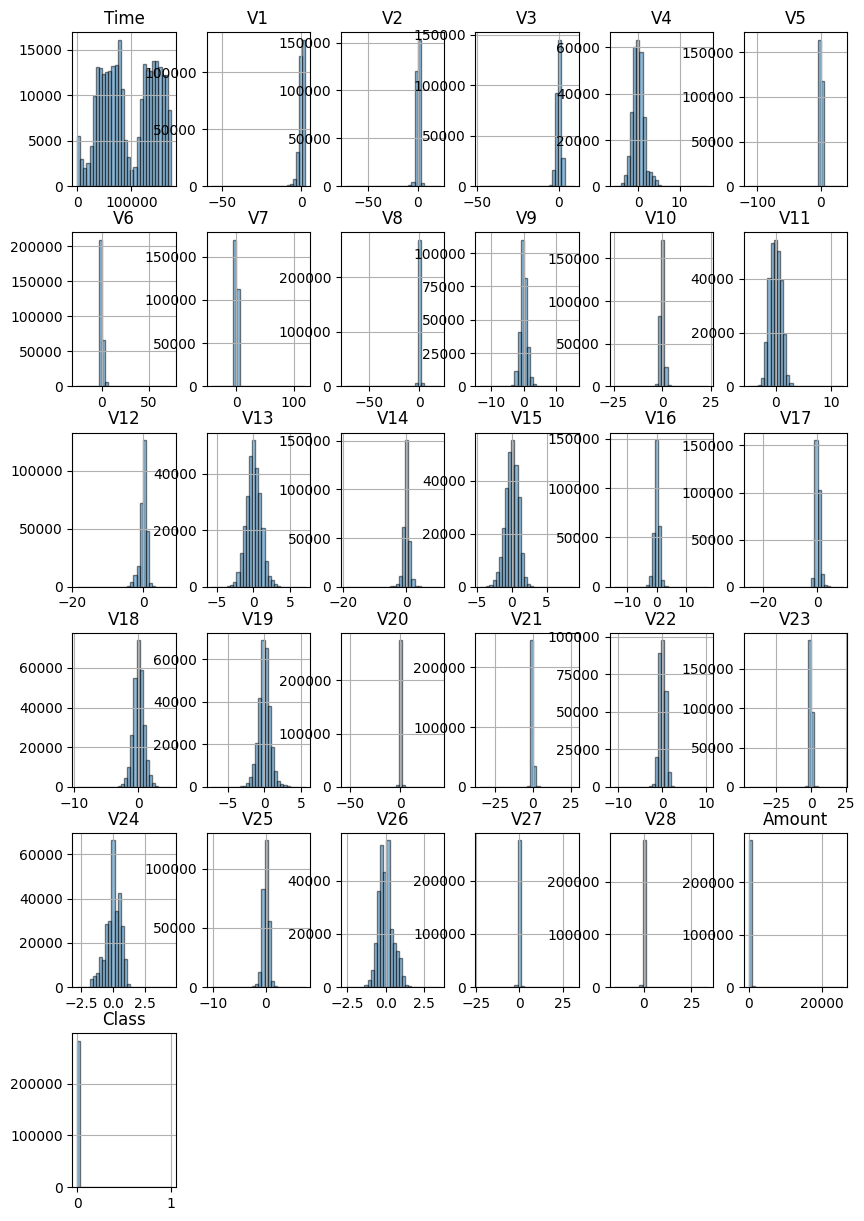

In [83]:

plt.Figure(figsize=(10,8))
df.hist(bins=30,edgecolor='black',alpha=0.5 ,figsize=(10,15))
plt.xlabel('lower_bounded_ip_address')
plt.ylabel('upper_bounded_ipadress')
plt.show()

In [24]:
df1.head(10)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan
6,16785408.0,16793599,China
7,16793600.0,16809983,Japan
8,16809984.0,16842751,Thailand
9,16842752.0,16843007,China


In [25]:
df1.tail()

,lower_bound_ip_address,upper_bound_ip_address,country
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore
138845,3.758096e+09,3758096383,Australia


In [26]:
df1.describe(include='all')

,lower_bound_ip_address,upper_bound_ip_address,country
count,1.388460e+05,1.388460e+05,138846
unique,NaN,NaN,235
top,NaN,NaN,United States
freq,NaN,NaN,46868
mean,2.724532e+09,2.724557e+09,NaN
std,8.975215e+08,8.974979e+08,NaN
min,1.677722e+07,1.677747e+07,NaN
25%,1.919930e+09,1.920008e+09,NaN
50%,3.230887e+09,3.230888e+09,NaN
75%,3.350465e+09,3.350466e+09,NaN


In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [28]:
df1['upper_bound_ip_address']=df1['upper_bound_ip_address'].astype(int)
df1

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [29]:
from scripts.data_cleaning import remove_duplicates
remove_duplicates(df1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [30]:
from scripts.data_cleaning import correct_data_types
correct_data_types(df1)

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


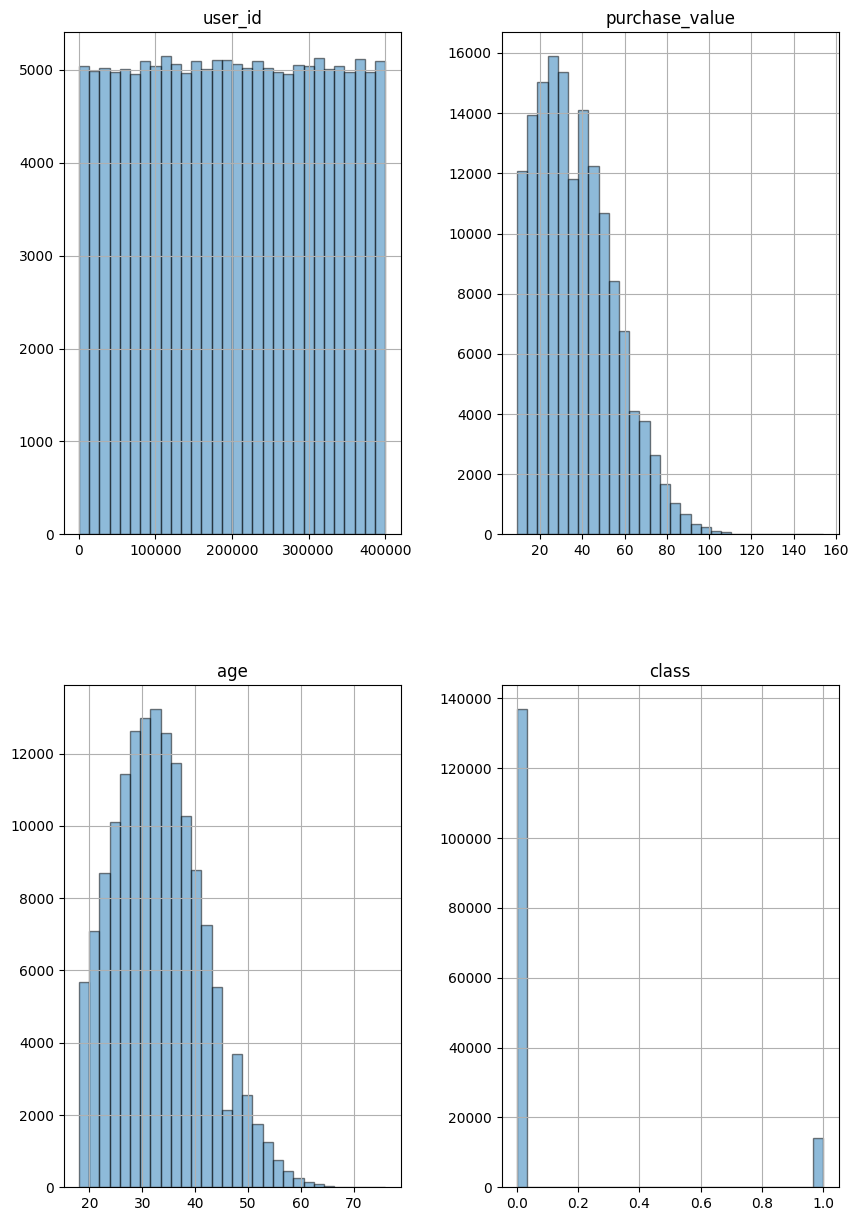

In [31]:
plt.Figure(figsize=(10,8))
df.hist(bins=30,edgecolor='black',alpha=0.5 ,figsize=(10,15))
plt.show()

In [ ]:
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [48]:
df2.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df2.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [20]:
df2['Amount']=StandardScaler().fit_transform(df2[['Amount']])
df2

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


the class indictates wheather the data is fraudalent or not (0= non fraudalent and 1= fraudalent transaction)

In [22]:
import sys
import os

In [ ]:
sys.appened

In [21]:
from scripts.data_cleaning import correct_data_types
correct_data_types(df2)

ModuleNotFoundError: No module named 'scripts.data_cleaning'

In [18]:
from scripts.data_cleaning import correct_data_types
correct_data_types(df2)

ModuleNotFoundError: No module named 'scripts.data_cleaning'

In [6]:
df2[['V1','V2','V3']].corr()

NameError: name 'df2' is not defined

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual


In [5]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax2 = sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    plt.show()
    plt.close()